In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 45s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


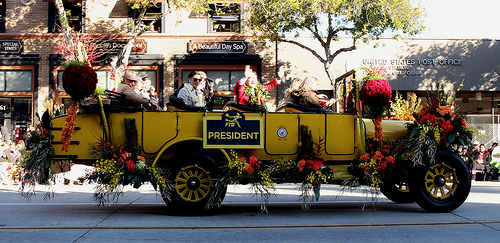

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

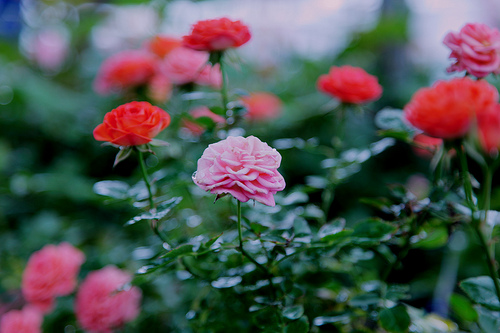

In [6]:
PIL.Image.open(str(roses[1]))

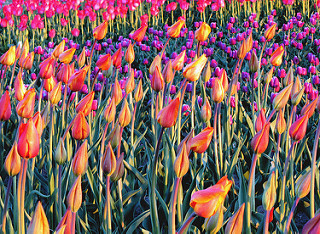

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

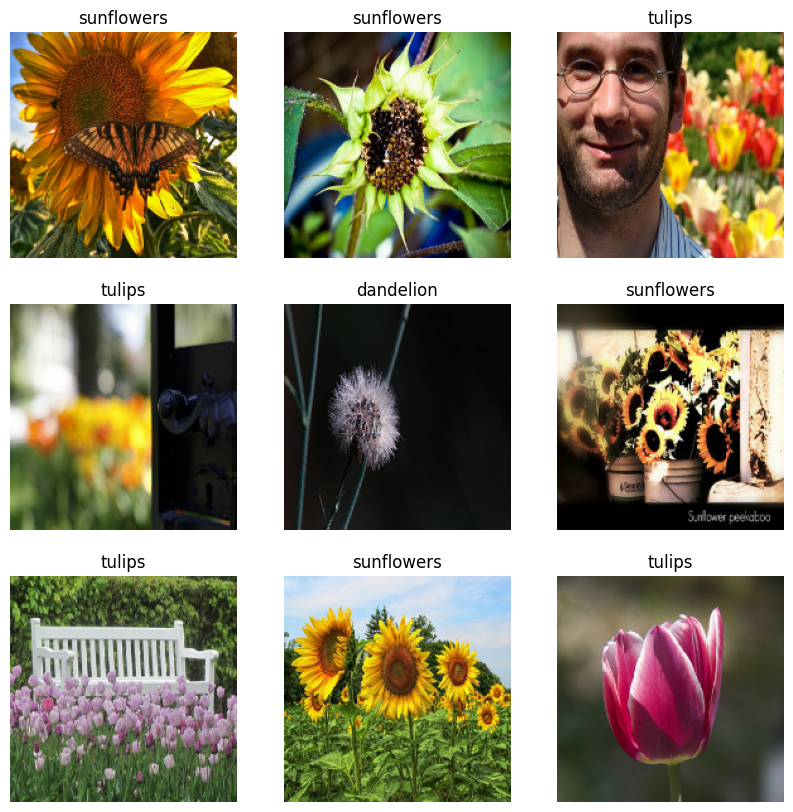

In [14]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
#the pixels of the image should be in between 0 and 1
print(np.min(first_image),np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 0.99918306


In [19]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64800)             0

In [22]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 12s 132ms/step - loss: 1.5332 - accuracy: 0.4179 - val_loss: 1.0911 - val_accuracy: 0.5545
Epoch 2/10
92/92 [==============================] - 11s 124ms/step - loss: 0.9650 - accuracy: 0.6243 - val_loss: 0.9915 - val_accuracy: 0.6090
Epoch 3/10
92/92 [==============================] - 11s 124ms/step - loss: 0.6969 - accuracy: 0.7469 - val_loss: 1.0009 - val_accuracy: 0.6049
Epoch 4/10
92/92 [==============================] - 12s 126ms/step - loss: 0.4199 - accuracy: 0.8525 - val_loss: 1.0301 - val_accuracy: 0.6294
Epoch 5/10
92/92 [==============================] - 11s 125ms/step - loss: 0.2188 - accuracy: 0.9424 - val_loss: 1.2961 - val_accuracy: 0.6022
Epoch 6/10
92/92 [==============================] - 12s 125ms/step - loss: 0.1162 - accuracy: 0.9734 - val_loss: 1.3489 - val_accuracy: 0.6281
Epoch 7/10
92/92 [==============================] - 12s 126ms/step - loss: 0.0659 - accuracy: 0.9850 - val_loss: 1.3347 - val_accuracy: 0.6144

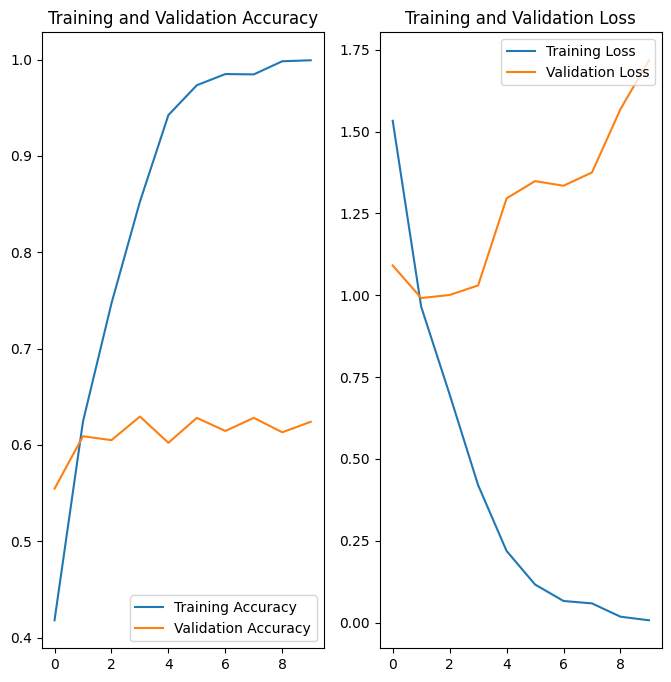

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

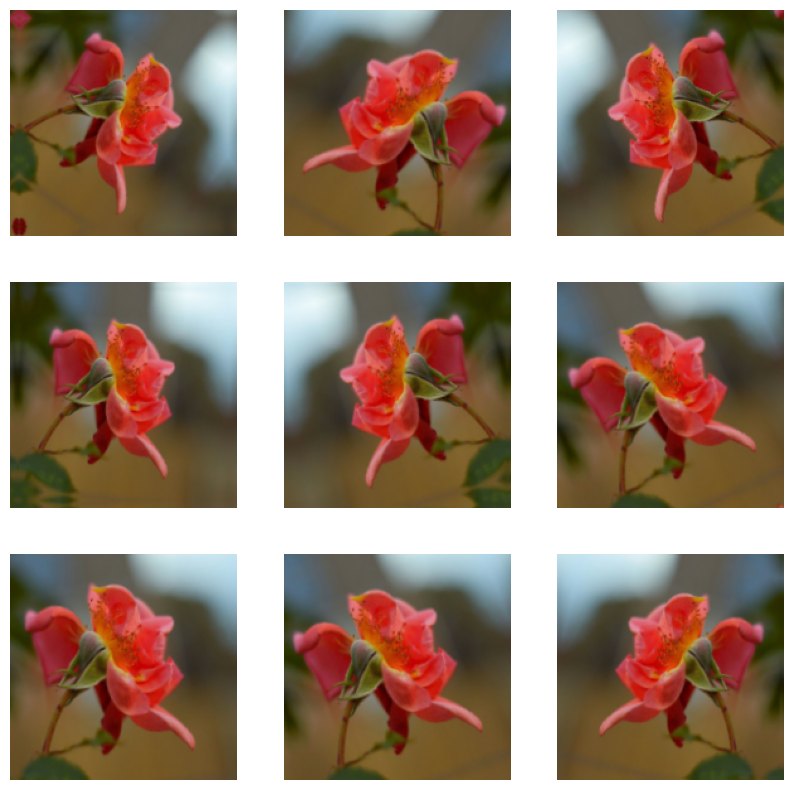

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [26]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [29]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 17s 171ms/step - loss: 1.2541 - accuracy: 0.4639 - val_loss: 1.0645 - val_accuracy: 0.6008
Epoch 2/15
92/92 [==============================] - 16s 171ms/step - loss: 1.0227 - accuracy: 0.5984 - val_loss: 0.9359 - val_accuracy: 0.6185
Epoch 3/15
92/92 [==============================] - 16s 169ms/step - loss: 0.9097 - accuracy: 0.6448 - val_loss: 0.9394 - val_accuracy: 0.6403
Epoch 4/15
92/92 [==============================] - 16s 171ms/step - loss: 0.8122 - accuracy: 0.6870 - val_loss: 0.8988 - val_accuracy: 0.6308
Epoch 5/15
92/92 [==============================] - 16s 172ms/step - loss: 0.7598 - accuracy: 0.7101 - val_loss: 0.8835 - val_accuracy: 0.6567
Epoch 6/15
92/92 [==============================] - 16s 174ms/step - loss: 0.7035 - accuracy: 0.7299 - val_loss: 0.7870 - val_accuracy: 0.6907
Epoch 7/15
92/92 [==============================] - 16s 174ms/step - loss: 0.6778 - accuracy: 0.7432 - val_loss: 0.7668 - val_accuracy: 0.6798

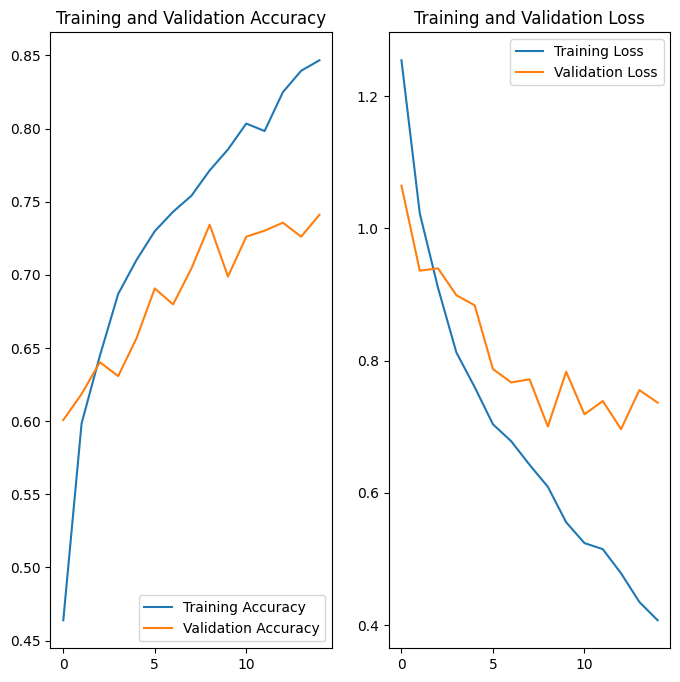

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 59ms/step
This image most likely belongs to sunflowers with a 99.42 percent confidence.


In [34]:
model.save("/Users/tanmay/Documents/Coding/Repositories/flower-classifier/model")

INFO:tensorflow:Assets written to: /Users/tanmay/Documents/Coding/Repositories/flower-classifier/model/assets


INFO:tensorflow:Assets written to: /Users/tanmay/Documents/Coding/Repositories/flower-classifier/model/assets


In [37]:
from tensorflow.keras.models import load_model, model_from_json

In [38]:
with open("model.json", "w") as json_file:
    json_file.write(model_json)